<a href="https://colab.research.google.com/github/zihan-qin/repos1/blob/master/zihanqin_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import keras
import os
import string
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from sklearn.metrics import accuracy_score

(a) In this problem, we are trying to build a classifier to analyze the sentiment of reviews. You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.

(b) Data Exploration and Pre-processing

i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.


iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [ ]:
#trainset = pd.DataFrame(columns=['content','class'])
#testset = pd.DataFrame(columns=['content','class'])
trainset = []
testset = []
path = "./drive/MyDrive/Final_project/Data/neg/"
for i in os.listdir(path):
  if int(i[2:5]) <= 999 and int(i[2:5]) >=700: 
    with open(path+i,'r') as f:
      testset.append([f.read(),-1])
#    testset = testset.append(tmp)
  else:
    with open(path+i,'r') as f:
      trainset.append([f.read(),-1])
#    trainset = trainset.append(tmp)
path = "./drive/MyDrive/Final_project/Data/pos/"
for i in os.listdir(path):
  if int(i[2:5]) <= 999 and int(i[2:5]) >=700: 
    with open(path+i,'r') as f:
      testset.append([f.read(),1])
#    testset = testset.append(tmp)
  else:
    with open(path+i,'r') as f:
      trainset.append([f.read(),1])
 #   trainset = trainset.append(tmp)

In [ ]:
trainset = pd.DataFrame(trainset,columns=['content','class'])
testset = pd.DataFrame(testset,columns=['content','class'])

ii. The data are pretty clean. Remove the punctuation and numbers from the data.


In [ ]:
def data_pre(dataset):
  dataset.index = range(len(dataset))
  for i in range(len(dataset)):
    tmp = dataset.loc[i,'content']
    tmp = tmp.translate(str.maketrans('','',string.punctuation))
    tmp = tmp.translate(str.maketrans('','',string.digits))
    tmp = tmp.translate(str.maketrans('\n',' '))
    tmp = tmp.translate(str.maketrans('\t',' '))
    dataset.loc[i,'content'] = tmp

In [ ]:
data_pre(trainset)
data_pre(testset)

iv. Count the number of unique words in the whole dataset (train + test) and print it out.

v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [ ]:
word_frec = {}
review_len = []
for i in trainset['content']:
  tmp = i.split()
  review_len.append(len(tmp))
  for word in tmp:
    word_frec[word] = word_frec.get(word,0) + 1
for i in testset['content']:
  tmp = i.split()
  review_len.append(len(tmp))
  for word in tmp:
    word_frec[word] = word_frec.get(word,0) + 1
print("unique words count:%d."%len(word_frec))
print("avg review length:%.2f."%np.mean(review_len))
print("std review length:%.2f."%np.std(review_len))

unique words count:46830.
avg review length:644.36.
std review length:284.98


ans:

iv: The number of unique words in the whole dataset is 46830.

v: The average review lengths is 644, the standard deviation of review lengths is 284.98.

vi. Plot the histogram of review lengths.

Text(0.5, 0, 'length')

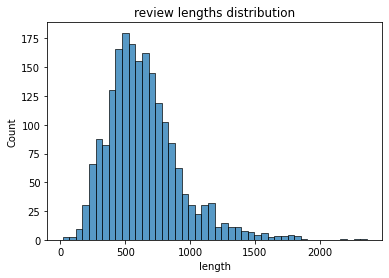

In [ ]:
sns.histplot(review_len)
plt.title('review lengths distribution')
plt.xlabel('length')

vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity / rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [ ]:
token = keras.preprocessing.text.Tokenizer(num_words=5000,lower=True,split=' ')
token.fit_on_texts(trainset['content'])

In [ ]:
train_token = token.texts_to_sequences(trainset['content'])
test_token = token.texts_to_sequences(testset['content'])

viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [ ]:
tok_len = int(np.quantile(review_len,0.7))
train_pad = pad_sequences(train_token,maxlen=tok_len,padding='pre',truncating='post',value=0)
test_pad = pad_sequences(test_token,maxlen=tok_len,padding='pre',truncating='post',value=0)

In [ ]:
train_y = trainset['class'].values
train_y[np.where(train_y == -1)] = 0



(d)

i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

ii. Report the train and test accuracies of this model.

In [ ]:
def MLP_model():
  model = keras.Sequential()
  #model.add(layers.Input())
  model.add(layers.Embedding(5000,32,input_length=tok_len))
  model.add(layers.Flatten())
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam')
  return model

In [ ]:
model = MLP_model()
model.fit(train_pad,train_y,epochs=2,batch_size=10,verbose=2)

Epoch 1/2
140/140 - 3s - loss: 0.6982 - 3s/epoch - 19ms/step
Epoch 2/2
140/140 - 1s - loss: 0.6606 - 689ms/epoch - 5ms/step


In [ ]:
test_y = testset['class'].values
test_y[np.where(test_y == -1)] = 0

In [ ]:
pred_train = model.predict(train_pad,verbose=0)
pred_train = np.where(pred_train<0.5,0,1)
train_acc = accuracy_score(train_y,pred_train)

pred_test = model.predict(test_pad,verbose=0)
pred_test = np.where(pred_test<0.5,0,1).ravel()
test_acc = accuracy_score(test_y,pred_test)
print('The training accuracy is:%.2f, the testing accuracy is %.2f.'%(train_acc,test_acc))

The training accuracy is:0.85, the testing accuracy is 0.61.


The training accuracy is:0.85, the testing accuracy is 0.61.

(e) One-Dimensional Convolutional Neural Network:

Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.


i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.


ii. Report the train and test accuracies of this model.

In [ ]:
def CNN1D_model():
  model = keras.Sequential()
  model.add(layers.Embedding(5000,32,input_length=tok_len))
#  model.add(layers.Flatten())
  model.add(layers.Conv1D(filters=32,kernel_size=3))
  model.add(layers.MaxPooling1D(pool_size=2,strides=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam')
  return model



In [ ]:
model2 = CNN1D_model()
model2.fit(train_pad,train_y,epochs=2,batch_size=10,verbose=2)

Epoch 1/2
140/140 - 5s - loss: 0.6982 - 5s/epoch - 35ms/step
Epoch 2/2
140/140 - 1s - loss: 0.6953 - 780ms/epoch - 6ms/step


In [ ]:
pred_train2 = model2.predict(train_pad,verbose=0)
pred_train2 = np.where(pred_train2<0.5,0,1).ravel()
train_acc2 = accuracy_score(train_y,pred_train2)

pred_test2 = model2.predict(test_pad,verbose=0)
pred_test2 = np.where(pred_test2<0.5,0,1).ravel()
test_acc2 = accuracy_score(test_y,pred_test2)

print('The training accuracy is:%.2f, the testing accuracy is %.2f.'%(train_acc2,test_acc2))

The training accuracy is:0.63, the testing accuracy is 0.53.


The training accuracy is:0.63, the testing accuracy is 0.53.

(f) Long Short-Term Memory Recurrent Neural Network:
The structure of the LSTM we are going to use is shown in the following figure.


i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.


ii. Report the train and test accuracies of this model.

In [ ]:
def LSTM_model():
  model = keras.Sequential()
  model.add(layers.Embedding(5000,32,input_length=tok_len))
  model.add(layers.LSTM(256,dropout=0.2))
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam')
  return model

In [ ]:
model3 = LSTM_model()
model3.fit(train_pad,train_y,epochs=10,batch_size=10,verbose=2)

Epoch 1/10
140/140 - 7s - loss: 0.6932 - 7s/epoch - 52ms/step
Epoch 2/10
140/140 - 4s - loss: 0.6450 - 4s/epoch - 27ms/step
Epoch 3/10
140/140 - 4s - loss: 0.4160 - 4s/epoch - 27ms/step
Epoch 4/10
140/140 - 4s - loss: 0.1855 - 4s/epoch - 26ms/step
Epoch 5/10
140/140 - 4s - loss: 0.0668 - 4s/epoch - 26ms/step
Epoch 6/10
140/140 - 4s - loss: 0.0482 - 4s/epoch - 26ms/step
Epoch 7/10
140/140 - 4s - loss: 0.0402 - 4s/epoch - 28ms/step
Epoch 8/10
140/140 - 4s - loss: 0.0220 - 4s/epoch - 28ms/step
Epoch 9/10
140/140 - 4s - loss: 0.0229 - 4s/epoch - 26ms/step
Epoch 10/10
140/140 - 4s - loss: 0.0125 - 4s/epoch - 28ms/step


In [ ]:
pred_train3 = model3.predict(train_pad,verbose=0)
pred_train3 = np.where(pred_train3<0.5,0,1).ravel()
train_acc3 = accuracy_score(train_y,pred_train3)

pred_test3 = model3.predict(test_pad,verbose=0)
pred_test3 = np.where(pred_test3<0.5,0,1).ravel()
test_acc3 = accuracy_score(test_y,pred_test3)

print('The training accuracy is:%.2f, the testing accuracy is %.2f.'%(train_acc3,test_acc3))

The training accuracy is:1.00, the testing accuracy is 0.66.


The training accuracy is:1.00, the testing accuracy is 0.66.